#Modelo de programación lineal

* Sea $G=(V,E)$ la gráfica que describe el problema. Con $V$ el conjunto de nodos (clientes) y $E$ el conjunto de aristas (conexiones entre clientes). En este caso tenemos que todos los clientes están conectados.

* Cada nodo $i\in V$ tiene asociado coordenadas geográficas $(c_x,c_y)$, volumen de entrega $w_i$ y frecuencia $a_i$.

* Sea, también, $p$ el número de territorios. En este caso $p=6$.

* El tamaño del territorio $V_k$ con $k\in \{1,...,p\}$ se tomará con respecto al volumen de entrega que está dado por $w^{(2)}(V_k)=\sum_{i\in V_k}w_i$. Y con respecto a la cantidad de clientes $w^{(1)}(V_k)=|V_k|$.

* La intersección entre territorios $V_k$ puede ser no vacía.

* La distancia entre nodos $j$ e $i$ es $d_{ij}$, $j\in V$.

* Para lograr que los clientes de un mismo territorio esten lo más cercanos entre si que se pueda, se opta por minimizar la dispersión dentro del territorio y para esto se considera un valor $\tau$ que sería la tolerancia para la desviación relativa del tamaño del territorio. El valor que se desearía alcanzar para el volumen de entrega está dado por $\mu^{(2)} = \sum_{i\in V}a_iw_i/p$. Mientras que el valor deseado de clientes es $\mu^{(1)} = \sum_{i\in V} a_i/p$

Por lo tanto, el MPL está estructurado de la siguiente forma:

Variables de decisión:

$$
x_{ij}=
\left\{
  \begin{aligned}
  1& \quad \text{si el nodo j es asignado al territorio con centro en } i;j, j\in V\\
  0& \quad \text{en otro caso}
  \end{aligned}
\right.
$$

Funciones objetivo

$$
\text{Min} \quad f_1 = \sum_{j\in V}\sum_{i\in V} d_{ij}x_{ij}\\
\text{Min} \quad f_2 = \max_{i\in V}\left\{\frac{1}{\mu^{(1)}}|\sum_{j\in V}x_{ij}-\mu^{(1)}x_{ij}| \right\}
$$

Sujeto a:

$$
\sum_{i\in V} x_{ii} = p\\
\sum_{i\in V} x_{ij} = a_j \quad \forall j\in V\\
\sum_{j\in V} w_j^{(2)}x_{ij} \geq (1-\tau^{(2)}) \mu^{(2)}x_{ii} \quad i\in V\\
\sum_{j\in V} w_j^{(2)}x_{ij} \leq (1-\tau^{(2)}) \mu^{(2)}x_{ii} \quad i\in V\\
x_{ij}\in \{0,1\} \quad i,j\in V
$$

#Heurística
Ahora bien, ya que éste es un problema NP-hard tendremos que utilizar una heurística para resolver el problema. 

#Fase de construcción
Iniciamos seleccionado un cliente aleatorio con un frecuencia igual a 1 que se convertirá en el primer centro. Para elegir los siguientes 6 se escoge un cliente a una distancia alrededor de la media de todos los puntos.

Teniendo los 6 centros se va agregando a cada uno de ellos los clientes con mayor frecuencia y más cercas a cada centro. Cuando ya no hay clientes con frecuencia mayor a 1 cerca del centro escoge a los más cercanos hasta llegar a un límite de clientes y de volumen de carga.

Se repite el algoritmo hasta cumplir toda la demanda


##Fase de post-procesamiento 
Se inicia con la partición de territorios de la fase de construcción. $S=\{V_1,...,V_p\}$ donde, para cada $V_k$, con $k\in K=\{1,...,p\}$ existe un centro $c(k)\in V_{k}$. Sea $q(i)=k$ el indice de territorio para cada $i \in V_{k}$. Para esta fase se pretenden optimizar 3 funcionen objetivo:

* Medida de dispersión 
$$
z_1(S) = \max_{j\in V_k,k\in K} \{d_{j c(k)}\}
$$

* Desviación máxima con respecto al número de clientes
$$
z_{2}(S) = \frac{1}{\mu^{(1)}} \max_{k\in K}\{\max\{w^{(1)}(V_{k})-\mu^{(1)},\mu^{(1)}-w^{(1)}(V_k)\}\}
$$

* Inviabilidad total

$$
z_3(S) = \frac{1}{\mu^{(2)}} \sum _{k\in K}\max\{w^{(2)}(V_k) - (1+\tau^{(2)})\mu^{(2)}, (1-\tau^{(2)})\mu^{(2)}-w^{(2)}(V_k),0\}
$$

Cada función objetivo se optimizara una tras otra, es decir, la solución obtenida para $z_1(S)$, $S_1$, se utilizará en $z_2(S^1)$ y su solución, $S_2$, en $z_3(S^2)$, y finalmente, la última solución, $S^3$, se utiliza para $z_1(S^3)$

Cada función se optimizará utilizando los siguientes métodos, consecutivamente, de forma similar a la descrita con las funciones objetivo:

* (1,0)-Reubicación: toma un nodo de un territorio y lo cambia a otro territorio.
* (1,1)-Intercambio: Intercambia de posición dos nodos de distintos territorios
* (2,0)-Reubicación: Toma dos nodos de un territorio y posiciona en otro distinto.
* (2,2)-Intercambio: Intercambia dos nodos de un territorio con dos de otro territorio.

La cantidad de veces que se realizará esto es fijada por el usuario. No se pasará a la siguiente función hasta que se haya encontrado una mejor solución o se haya terminado el número de iteraciones.

A su vez, el proceso de optimización de todas las funciones se repite según un límite de iteraciones.


#Código

Librerías necesarias

In [1]:
import pandas as pd
import sys
import numpy as np
import random 
from statistics import mean
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math
from sklearn.cluster import KMeans
from sklearn import datasets

Se conecta con Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de los datos

In [6]:
import warnings
import os
%matplotlib inline
warnings.filterwarnings("ignore")
# Fijar directorio
os.chdir('/content/drive/My Drive/')

#Carpeta de datos de ubicaciones
data_csv = 'reto-mexico-2020-main/data/ubicaciones.csv'
data = pd.read_csv(data_csv)

In [7]:
data.head()

,Id_Cliente,id_Agencia,Frecuencia,Vol_Entrega,lat,lon
0,1,A1,1,2.0,20.506052,-98.212377
1,2,A1,1,17.0,20.458128,-98.221248
2,3,A1,1,2.0,20.530427,-98.236860
3,4,A1,3,15.0,20.488655,-98.202940
4,5,A1,1,2.0,20.533253,-98.219669


Se modifica la base para hacerla más manejable

In [8]:
X=data[['Id_Cliente',"Frecuencia","Vol_Entrega","lat","lon"]].to_numpy()
X=list(X)

Valores deseados de balance

In [9]:
climit=data.Frecuencia.sum()/6
vmax=data.Frecuencia*data.Vol_Entrega
vlim=vmax.sum()/6

Función de distancia

In [3]:
def haversine(coord1, coord2):
    R = 6372800 
    i,a,b,lat1, lon1 = coord1
    i,a,b,lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

Matriz de distancias

In [10]:
ntotal=len(X)
evalu=[]
for i in range(ntotal):
    ss=[]
    for j in range(ntotal):
        ss.append(0)
    evalu.append(ss)
for i in range(ntotal):
    for j in range(ntotal):
        if j>i:
            evalu[i][j]=haversine(X[i], X[j])
            evalu[j][i]=evalu[i][j]

##Fase de construcción

Funciones necesarias

In [11]:
def f(y,C):
    cliente1=[]
    cliente2=[]
    cliente3=[]
    cliente4=[]
    cliente5=[]
    cliente6=[]
    dist=0
    maximos=[]
    for i in range(len(y)):
        if y[i]==0:
            cliente1.append(i)
        if y[i]==1:
            cliente2.append(i)
        if y[i]==2:
            cliente3.append(i)
        if y[i]==3:
            cliente4.append(i)
        if y[i]==4:
            cliente5.append(i)
        if y[i]==5:
            cliente6.append(i)
    aux=[]
    for i in cliente1:
        aux.append(evalu[C[0]][i])
    maximos.append(max(aux))
    dist+=max(aux)
    aux=[]
    for i in cliente2:
        aux.append(evalu[C[1]][i])
    maximos.append(max(aux))
    dist+=max(aux)
    aux=[]
    for i in cliente3:
        aux.append(evalu[C[2]][i])
    maximos.append(max(aux))
    dist+=max(aux)
    aux=[]
    for i in cliente4:
        aux.append(evalu[C[3]][i])
    maximos.append(max(aux))
    dist+=max(aux)
    aux=[]
    for i in cliente5:
        aux.append(evalu[C[4]][i])
    maximos.append(max(aux))
    dist+=max(aux)
    aux=[]
    for i in cliente6:
        aux.append(evalu[C[5]][i])
    maximos.append(max(aux))
    dist+=max(aux)
    return dist,maximos 
def centros(X):
    C=[]
    aux=random.choice(X)
    while(aux[1]!=1):
        aux=random.choice(X)
    C.append(int(aux[0]))
    dist=evalu[int(C[0]-1)]
    aux=random.choice(dist)
    while(aux<=mean(dist)*0.7):
        aux=random.choice(dist)
    indx=dist.index(aux)
    C.append(int(X[indx][0]))
    for i in range(4):
        dist=np.array(dist)
        dist+=np.array(evalu[int(C[i+1]-1)])
        dist=list(dist)
        aux=random.choice(dist)
        while(aux<=mean(dist)*0.9):
            aux=random.choice(dist)
        indx=dist.index(aux)
        C.append(int(X[indx][0]))    
    return C

def clientes(C,X,asig,frec):
    for i in range(6):
        dist=evalu[C[i]-1].copy()
        dist[C[i]-1]=1000000000
        asig[i][C[i]-1]=1
        frec[C[i]-1]-=1
        maxv=X[C[i]-1][2]
        j=1
        f=[]
        for k in range(len(frec)):
            if(frec[k]>1):
                f.append(dist[k])
        for k in range(len(f)):
            aux=min(f)
            ind=f.index(aux)
            indx=dist.index(aux)
            while(frec[indx]<1):
                dist[indx]=10000000000
                f[ind]=10000000000
                aux=min(f)
                indx=dist.index(aux)
                ind=f.index(aux)
            dist[indx]=1000000000
            f[ind]=10000000000
            asig[i][indx]=1
            frec[indx]-=1
            maxv+=X[indx][2]
            j=j+1
        while(sum(frec)>=1):
                aux=min(dist)
                indx=dist.index(aux)
                while(frec[indx]<1):
                    dist[indx]=10000000000
                    aux=min(dist)
                    indx=dist.index(aux)
                dist[indx]=1000000000
                asig[i][indx]=1
                frec[indx]-=1
                maxv+=X[indx][2]
                j=j+1
                if(maxv>=vlim*1.1):
                    break
                if(j>=climit*1.1):
                    break
        print(maxv,vlim,j,climit)

Construcción de los territorios iniciales

In [142]:
k=False
while( k==False):
    asig=[]
    for i in range(6):
        ss=[]
        for j in range(ntotal):
            ss.append(0)
        asig.append(ss)
    frec=list(np.array(data.Frecuencia))

    a=centros(X)

    print(a)

    clientes(a,X,asig,frec)
    j=0

    for i in frec:
        if(i==0):
            j+=1
    if(j==3625):
        k=True
        

[2460, 110, 36, 443, 1799, 581]
9986.499999996 9066.666666664665 634 662.8333333333334
10033.499999996 9066.666666664665 641 662.8333333333334
8305.000000003 9066.666666664665 730 662.8333333333334
9881.16666666 9066.666666664665 730 662.8333333333334
9187.333333333 9066.666666664665 730 662.8333333333334
7006.5 9066.666666664665 512 662.8333333333334
[1122, 272, 827, 2506, 2426, 2597]
9974.499999996 9066.666666664665 676 662.8333333333334
9228.499999996 9066.666666664665 730 662.8333333333334
9928.833333333001 9066.666666664665 730 662.8333333333334
9686.99999999 9066.666666664665 730 662.8333333333334
9981.000000003 9066.666666664665 657 662.8333333333334
5424.16666667 9066.666666664665 454 662.8333333333334
[2795, 1936, 1345, 1551, 292, 1500]
9981.499999996 9066.666666664665 670 662.8333333333334
9975.999999996 9066.666666664665 705 662.8333333333334
9980.83333333 9066.666666664665 639 662.8333333333334
9991.166666673 9066.666666664665 711 662.8333333333334
8424.500000003001 9066.66

Prueba de factibilidad

In [143]:
len
for i in frec:
    if(i!=0):
        print(i)

Gráfica de territorios

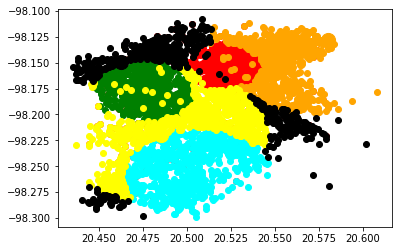

In [14]:
x=0
colores=['red','green','orange','cyan','yellow','black']
for i in range(len(a)):
    plt.scatter(data.lat[a[i]-1],data.lon[a[i]-1],c=colores[i],s=200)
    for j in range(len(asig[i])):
        if(asig[i][j]==1):
            plt.scatter(data.lat[j],data.lon[j],c=colores[i])

##Fase de Post-Procesamiento

Valor deseado de volumen y clientes.

In [34]:
mu_1 = climit
mu_2 = vlim

Se crea una matriz con el id de cada cliente segun el territorio

In [254]:
def codif(M):
  S1 = []
  for i in range(6):
    aux = []
    for j in range(len(M[i])):
      if(M[i][j]==1):
        aux.append(j)
    S1.append(aux)
  return S1

In [255]:
S = codif(asig)

Función que obtiene el centro que minimiza la distancia máxima 

In [35]:
def centro(nodos):
  max_dist = []
  for i in nodos:
    aux1 = []
    for j in nodos:
      aux1.append(evalu[i][j])
    max_dist.append(max(aux1))
  return int(nodos[np.argmin(max_dist)])

Funciones objetivo para optimizar

In [230]:
def z_1(S):
  dist = []
  for i in range(6):
    for j in S[i]:
      dist.append(evalu[j][a[i]])
  return max(dist)

def z_2(S):
  aux = []
  for i in range(6):
    w_1 = len(S[i])
    aux.append(max([w_1-mu_1,mu_1-w_1]))
  aux1 = 1/mu_1
  aux2 = max(aux)
  return aux1*aux2

def z_3(S,tau):
  aux = []
  for i in range(6):
    w_2 = 0
    for j in S[i]:
      w_2 += X[j][1]
    aux.append(max([w_2-(1+tau)*mu_2,(1-tau)*mu_2-w_2,0]))
  aux1 = 1/mu_2
  aux2 = np.sum(aux)
  return aux1*aux2

Función para copiar matrices

In [231]:
def copia(S):
  S1 = []
  for i in range(len(S)):
    S1.append(list(S[i]))
  return S1

Y ahora las funciones para intercambiar nodos, primeramente la (1,0)-Reubicación

In [232]:
def R1(S,max,tau):
  S1 = copia(S)
  #primera función a optimizar
  f1 = z_1(S1)
  a = 0
  i = 0
  while ((a==0) and (i<=max)):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k = random.sample(S1[k[0]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k[0] in S1[k[1]]):
      i_k = random.sample(S1[k[0]],1)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k[0])
    S2[k[1]].append(i_k[0])
    f2 = z_1(S2)
    #Evalua el desempeño de la nueva partición 
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  #Segunda función a optimizar
  f1 = z_2(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k = random.sample(S1[k[0]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k[0] in S1[k[1]]):
      i_k = random.sample(S1[k[0]],1)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k[0])
    S2[k[1]].append(i_k[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_2(S2)
    if (f2<f1):
      S1 = copia(S2)
      a = 1
    i+=1

  #Tercer función a optimizar
  f1 = z_3(S1,tau)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k = random.sample(S1[k[0]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k[0] in S1[k[1]]):
      i_k = random.sample(S1[k[0]],1)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k[0])
    S2[k[1]].append(i_k[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_3(S2,tau)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  #Volvemos con la primer función
  f1 = z_1(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k = random.sample(S1[k[0]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k[0] in S1[k[1]]):
      i_k = random.sample(S1[k[0]],1)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k[0])
    S2[k[1]].append(i_k[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_1(S2)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  return S1

In [83]:
S111 = R1(S,10,.5)

Función (1,1)-Intercambio

In [233]:
def I1(S,max,tau):
  S1 = copia(S)
  #primera función a optimizar
  f1 = z_1(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k1 = random.sample(S1[k[0]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k1[0] in S1[k[1]]):
      i_k1 = random.sample(S1[k[0]],1)
    #Ahora en el otro territorio
    i_k2 = random.sample(S1[k[1]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k2[0] in S1[k[0]]):
      i_k2 = random.sample(S1[k[1]],1)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k1[0])
    S2[k[1]].append(i_k1[0])
    S2[k[1]].remove(i_k2[0])
    S2[k[0]].append(i_k2[0])
    f2 = z_1(S2)
    #Evalua el desempeño de la nueva partición 
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  #Segunda función a optimizar
  f1 = z_2(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k1 = random.sample(S1[k[0]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k1[0] in S1[k[1]]):
      i_k1 = random.sample(S1[k[0]],1)
    #Ahora en el otro territorio
    i_k2 = random.sample(S1[k[1]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k2[0] in S1[k[0]]):
      i_k2 = random.sample(S1[k[1]],1)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k1[0])
    S2[k[1]].append(i_k1[0])
    S2[k[1]].remove(i_k2[0])
    S2[k[0]].append(i_k2[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_2(S2)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  #Tercer función a optimizar
  f1 = z_3(S1,tau)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k1 = random.sample(S1[k[0]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k1[0] in S1[k[1]]):
      i_k1 = random.sample(S1[k[0]],1)
    #Ahora en el otro territorio
    i_k2 = random.sample(S1[k[1]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k2[0] in S1[k[0]]):
      i_k2 = random.sample(S1[k[1]],1)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k1[0])
    S2[k[1]].append(i_k1[0])
    S2[k[1]].remove(i_k2[0])
    S2[k[0]].append(i_k2[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_3(S2,tau)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  #Volvemos con la primer función
  f1 = z_1(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k1 = random.sample(S1[k[0]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k1[0] in S1[k[1]]):
      i_k1 = random.sample(S1[k[0]],1)
    #Ahora en el otro territorio
    i_k2 = random.sample(S1[k[1]],1)
    #Busca un nodo que no se encuentre en el otro territorio
    while (i_k2[0] in S1[k[0]]):
      i_k2 = random.sample(S1[k[1]],1)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k1[0])
    S2[k[1]].append(i_k1[0])
    S2[k[1]].remove(i_k2[0])
    S2[k[0]].append(i_k2[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_1(S2)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  return S1

In [85]:
S111 = I1(S,10,.5)

Función (2,0)-Reubicación

In [234]:
def R2(S,max,tau):
  S1 = copia(S)
  #primera función a optimizar
  f1 = z_1(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k = random.sample(S1[k[0]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k[0] in S1[k[1]]) or (i_k[1] in S1[k[1]])):
      i_k = random.sample(S1[k[0]],2)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k[1])
    S2[k[0]].remove(i_k[0])
    S2[k[1]].append(i_k[1])
    S2[k[1]].append(i_k[0])
    f2 = z_1(S2)
    #Evalua el desempeño de la nueva partición 
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  #Segunda función a optimizar
  f1 = z_2(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k = random.sample(S1[k[0]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k[0] in S1[k[1]]) or (i_k[1] in S1[k[1]])):
      i_k = random.sample(S1[k[0]],2)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k[1])
    S2[k[0]].remove(i_k[0])
    S2[k[1]].append(i_k[1])
    S2[k[1]].append(i_k[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_2(S2)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  #Tercer función a optimizar
  f1 = z_3(S1,tau)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k = random.sample(S1[k[0]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k[0] in S1[k[1]]) or (i_k[1] in S1[k[1]])):
      i_k = random.sample(S1[k[0]],2)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k[1])
    S2[k[0]].remove(i_k[0])
    S2[k[1]].append(i_k[1])
    S2[k[1]].append(i_k[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_3(S2,tau)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1
 
  #Volvemos con la primer función
  f1 = z_1(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k = random.sample(S1[k[0]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k[0] in S1[k[1]]) or (i_k[1] in S1[k[1]])):
      i_k = random.sample(S1[k[0]],2)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k[1])
    S2[k[0]].remove(i_k[0])
    S2[k[1]].append(i_k[1])
    S2[k[1]].append(i_k[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_1(S2)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  return S1

In [87]:
S111 = R2(S,10,.5)

Función (2,2)-Intercambio

In [235]:
def I2(S,max,tau):
  S1 = copia(S)
  #primera función a optimizar
  f1 = z_1(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k1 = random.sample(S1[k[0]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k1[0] in S1[k[1]]) or (i_k1[1] in S1[k[1]])):
      i_k1 = random.sample(S1[k[0]],2)
    #Elige un nodo al azar
    i_k2 = random.sample(S1[k[1]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k2[0] in S1[k[0]]) or (i_k2[1] in S1[k[0]])):
      i_k2 = random.sample(S1[k[1]],2)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k1[1])
    S2[k[0]].remove(i_k1[0])
    S2[k[1]].append(i_k1[1])
    S2[k[1]].append(i_k1[0])
    S2[k[1]].remove(i_k2[1])
    S2[k[1]].remove(i_k2[0])
    S2[k[0]].append(i_k2[1])
    S2[k[0]].append(i_k2[0])
    f2 = z_1(S2)
    #Evalua el desempeño de la nueva partición 
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  #Segunda función a optimizar
  f1 = z_2(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k1 = random.sample(S1[k[0]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k1[0] in S1[k[1]]) or (i_k1[1] in S1[k[1]])):
      i_k1 = random.sample(S1[k[0]],2)
    #Elige un nodo al azar
    i_k2 = random.sample(S1[k[1]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k2[0] in S1[k[0]]) or (i_k2[1] in S1[k[0]])):
      i_k2 = random.sample(S1[k[1]],2)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k1[1])
    S2[k[0]].remove(i_k1[0])
    S2[k[1]].append(i_k1[1])
    S2[k[1]].append(i_k1[0])
    S2[k[1]].remove(i_k2[1])
    S2[k[1]].remove(i_k2[0])
    S2[k[0]].append(i_k2[1])
    S2[k[0]].append(i_k2[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_2(S2)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1
    
  #Tercer función a optimizar
  f1 = z_3(S1,tau)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k1 = random.sample(S1[k[0]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k1[0] in S1[k[1]]) or (i_k1[1] in S1[k[1]])):
      i_k1 = random.sample(S1[k[0]],2)
    #Elige un nodo al azar
    i_k2 = random.sample(S1[k[1]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k2[0] in S1[k[0]]) or (i_k2[1] in S1[k[0]])):
      i_k2 = random.sample(S1[k[1]],2)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k1[1])
    S2[k[0]].remove(i_k1[0])
    S2[k[1]].append(i_k1[1])
    S2[k[1]].append(i_k1[0])
    S2[k[1]].remove(i_k2[1])
    S2[k[1]].remove(i_k2[0])
    S2[k[0]].append(i_k2[1])
    S2[k[0]].append(i_k2[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_3(S2,tau)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1
    
  #Volvemos con la primer función
  f1 = z_1(S1)
  a = 0
  i = 0
  while (a==0 and i<=max):
    k = random.sample(list(range(6)),2)
    #Elige un nodo al azar
    i_k1 = random.sample(S1[k[0]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k1[0] in S1[k[1]]) or (i_k1[1] in S1[k[1]])):
      i_k1 = random.sample(S1[k[0]],2)
    #Elige un nodo al azar
    i_k2 = random.sample(S1[k[1]],2)
    #Busca nodos que no se encuentren en el otro territorio
    while ((i_k2[0] in S1[k[0]]) or (i_k2[1] in S1[k[0]])):
      i_k2 = random.sample(S1[k[1]],2)
    S2 = copia(S1)
    #Elimina el nodo de un territorio para colocarlo en el otro
    S2[k[0]].remove(i_k1[1])
    S2[k[0]].remove(i_k1[0])
    S2[k[1]].append(i_k1[1])
    S2[k[1]].append(i_k1[0])
    S2[k[1]].remove(i_k2[1])
    S2[k[1]].remove(i_k2[0])
    S2[k[0]].append(i_k2[1])
    S2[k[0]].append(i_k2[0])
    #Evalua el desempeño de la nueva partición 
    f2 = z_1(S2)
    if (f2<f1):
      S1 = copia(S2)
      a=1
    i+=1

  return S1

In [260]:
S111 = I2(S,10,.05)

Optimización

In [271]:
def optimizador(S,tau,max_1,max_2):
  S1 = copia(S)
  for i in range(max_1):
    if (i%100==1):
      print(i)
    S2 = R1(S1,max_2,tau)
    S3 = I1(S2,max_2,tau)
    S4 = R2(S3,max_2,tau)
    S1 = I2(S4,max_2,tau)
  return S1

In [272]:
tau = 0.05
max_1 = 2500
max_2 = 10
S_opt = optimizador(S,tau,max_1,max_2)

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401


Decodificador

In [216]:
def decod(S_1):
  aux = [[0 for i in range(ntotal)] for j in range(6)]
  for i in range(6):
    for j in S_1[i]:
      aux[i][j]=1
  return aux

Función que prueba la factibilidad

In [208]:
def factib(S_1):
  aux = decod(S_1)
  f = True
  for i in range(ntotal):
    aux2 = 0
    for j in range(6):
      aux2 += aux[j][i]
    if(aux2!=X[i][1]):
      f = False
  return f

Prueba de factibilidad

In [273]:
ff = factib(S_opt)
ff

True

Gáfica de zonas

In [274]:
asig2 = decod(S_opt)

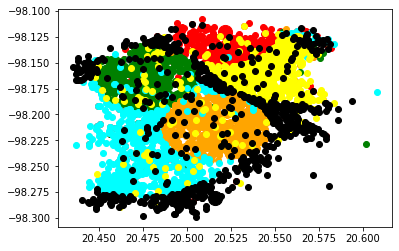

In [275]:
x=0
colores=['red','green','orange','cyan','yellow','black']
for i in range(len(a)):
    plt.scatter(data.lat[a[i]-1],data.lon[a[i]-1],c=colores[i],s=200)
    for j in range(len(asig2[i])):
        if(asig2[i][j]==1):
            plt.scatter(data.lat[j],data.lon[j],c=colores[i])

Creación de la base de datos

In [276]:
out=pd.DataFrame(asig2)

In [277]:
out=out.T
out['C'] = np.arange(1,len(out)+1)
out.columns = ['D1','D2','D3','D4','D5','D6','Id_Cliente']
out=out[['Id_Cliente','D1','D2','D3','D4','D5','D6']]

In [279]:
out.to_csv('out.csv',index=False)